In [ ]:
"""
!pip install segmentation_models
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0
"""

In [1]:
import glob
import os.path 
import cv2
import numpy as np 
import matplotlib
from matplotlib.pyplot import  imshow, show
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
#from skimage.color import gray2rgb
#from skimage.io import imsave, imread


import datetime
from PIL import Image

from __future__ import print_function

import numpy as np
from skimage.transform import resize


import pandas as pd

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
import segmentation_models as sm
sm.set_framework('tf.keras')
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.utils import plot_model

from Double_Unet_model import Double_UNET
from classification_model import classification_model

from preprocess import preprocess_test_data

from Submission  import final, prep

from plotting import predict_output_plot

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


# Downloading data

In [5]:
!curl --header 'Host: doc-0k-8o-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --cookie 'AUTH_5juv89o74sbfsi2477h6i6q5p1q008g0_nonce=e3re1laevdl40' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-0k-8o-docs.googleusercontent.com/docs/securesc/k60770kb8oj2avavfutuv1mfvl7m8t6h/qf1iv88jssq8r55p78c8s2v3j0dhjgri/1608042900000/00202388873488899107/00202388873488899107/1_cmtiu9Y4NQdJlexN3Xu-dgtEnR8rf3-?e=download&authuser=1&nonce=e3re1laevdl40&user=00202388873488899107&hash=rv65cbsgg0t8mtij0c40aj9lbptit9bp' --output 'Double_UNET_model_weights.h5'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  322M    0  322M    0     0  91.2M      0 --:--:--  0:00:03 --:--:-- 91.2M


In [6]:
!curl --header 'Host: doc-14-8o-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --cookie 'AUTH_5juv89o74sbfsi2477h6i6q5p1q008g0=00202388873488899107|1608042900000|cutn0262kcq7q6egf1p1apimqrmgpmn1' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-14-8o-docs.googleusercontent.com/docs/securesc/k60770kb8oj2avavfutuv1mfvl7m8t6h/lgmdurt485vqvrtq0he71ng53pumhgnl/1608042900000/00202388873488899107/00202388873488899107/1VBEdL4r8cdSfrSqypCsEggz8W2BI4B5b?e=download&authuser=1' --output 'Classification_model_weights.h5'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.2M    0 11.2M    0     0  40.9M      0 --:--:-- --:--:-- --:--:-- 40.8M


In [4]:
!curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5144/862050/compressed/test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1608198794&Signature=jkdT%2BwQbUCD%2BG19OrAuAKOB7u%2FkXmWMu34TxMO%2F0uX7oOp6hfsBIz%2Bm3PWvY667uHhxgMdwE3ao61kqk1dbjYVnNvn33kXTa%2BClPyqkNIrxQmsXzfOTcAa%2FqESR3ryKQGIjwSLQvbWG2FcCjtxY%2Fw4euaWBh6Mms%2FSstPWSUbCLW%2B0Cw5Bfn2z9IerE9vFhyshJx9HJIqT7aHpb8C8YhxHfTvH5Wd32qgsnUuwtSksnlpjFqU4HlHoQ81b5Q39hAa3%2BaFPRBp%2B1ULTV3iO6LK5BYPL8xBlsSWCC%2FLFSgcdT9P1l%2BX%2BwrHTrZ6c9PPqCp0JhdnzDk%2By1ustgEncyX5w%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.zip' --output 'test.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1065M  100 1065M    0     0   111M      0  0:00:09  0:00:09 --:--:--  115M


In [ ]:
! unzip test.zip
! mkdir test
! mv *.tif test/


# Main function


Preprocessing Images completed



Succesfully generated the file
Completed predictions processing


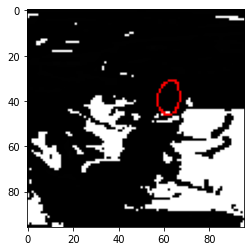

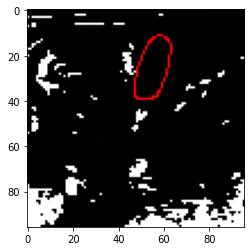

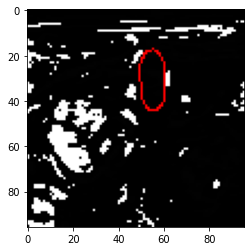

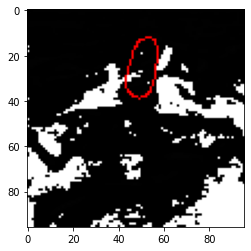

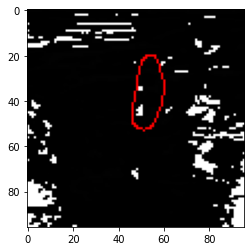

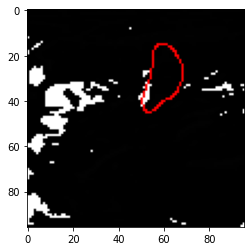

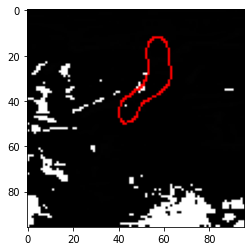

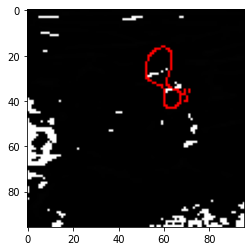

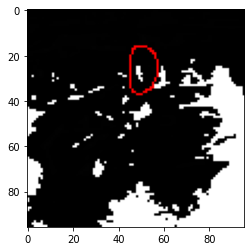

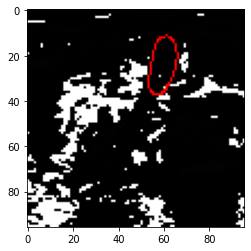

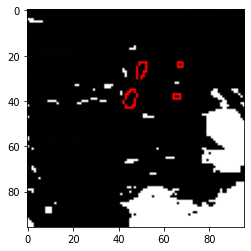

In [2]:
if __name__ == '__main__':
    classification_model= classification_model()
    double_unet=Double_UNET()

    imgs_test, test_ids=preprocess_test_data()
    final(imgs_test, test_ids, classification_model, double_unet)
    predict_output_plot(classification_model, double_unet, imgs_test)


